
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.18?urlpath=lab/tree/analysis_1.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[analysis_1.ipynb](../_static/notebooks/analysis_1.ipynb) |
[analysis_1.py](../_static/notebooks/analysis_1.py)
</div>


# First analysis with gammapy high level interface

## Prerequisites:

- Understanding the gammapy data workflow, in particular what are DL3 events and intrument response functions (IRF).

## Context

This notebook is an introduction to gammapy analysis using the high level interface. 

Gammapy analysis consists in two main steps. 

The first one is data reduction: user selected observations  are reduced to a geometry defined by the user. 
It can be 1D (spectrum from a given extraction region) or 3D (with a sky projection and an energy axis). 
The resulting reduced data and instrument response functions (IRF) are called datasets in Gammapy.

The second step consists in setting a physical model on the datasets and fitting it to obtain relevant physical informations.


**Objective: Create a 3D dataset of the Crab using the H.E.S.S. DL3 data release 1 and perform a simple model fitting of the Crab nebula.**

## Proposed approach:

This notebook uses the high level `Analysis` class to orchestrate data reduction. In its current state, `Analysis` supports the standard analysis cases of joint or stacked 3D and 1D analyses. It is instantiated with an `AnalysisConfig` object that gives access to analysis parameters either directly or via a YAML config file. 

To see what is happening under-the-hood and to get an idea of the internal API, a second notebook performs the same analysis without using the `Analysis` class. 

In summary, we have to:

- Create an `~gammapy.analysis.AnalysisConfig` object and edit it to define the analysis configuration:
    - Define what observations to use
    - Define the geometry of the dataset (data and IRFs)
    - Define the model we want to fit on the dataset.
- Instantiate a `~gammapy.analysis.Analysis` from this configuration and run the different analysis steps
    - Observation selection
    - Data reduction
    - Model fitting
    - Estimating flux points

Finally we will compare the results against a reference model.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
from astropy import units as u
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.modeling.models import create_crab_spectral_model

## Analysis configuration

For configuration of the analysis we use the [YAML](https://en.wikipedia.org/wiki/YAML) data format. YAML is a machine readable serialisation format, that is also friendly for humans to read. In this tutorial we will write the configuration file just using Python strings, but of course the file can be created and modified with any text editor of your choice.

Here is what the configuration for our analysis looks like:

In [3]:
config = AnalysisConfig()
# the AnalysisConfig gives access to the various parameters used from logging to reduced dataset geometries
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir: {frame: null, lon: null, lat: null}
                binsize: 0.02 deg
                fov: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 0.1 TeV, max: 10.0 TeV, nbins: 30}
                energy_true: {min: 0.1 TeV, max: 10.0 TeV, nbins: 30}
        map_selection: [counts, exposure, background, psf, edisp]
        background:
            method: null
            exclusion: null
            parameters: {}
        safe_m

### Setting the data to use

We want to use Crab runs from the H.E.S.S. DL3-DR1. We define here the datastore and a cone search of observations pointing with 5 degrees of the Crab nebula.
Parameters can be set directly or as a python dict.

In [4]:
# We define the datastore containing the data
config.observations.datastore = "$GAMMAPY_DATA/hess-dl3-dr1"

# We define the cone search parameters
config.observations.obs_cone.frame = "icrs"
config.observations.obs_cone.lon = "83.633 deg"
config.observations.obs_cone.lat = "22.014 deg"
config.observations.obs_cone.radius = "5 deg"

# Equivalently we could have set parameters with a python dict
# config.observations.obs_cone = {"frame": "icrs", "lon": "83.633 deg", "lat": "22.014 deg", "radius": "5 deg"}

### Setting the reduced datasets geometry

In [5]:
# We want to perform a 3D analysis
config.datasets.type = "3d"
# We want to stack the data into a single reduced dataset
config.datasets.stack = True

# We fix the WCS geometry of the datasets
config.datasets.geom.wcs.skydir = {
    "lon": "83.633 deg",
    "lat": "22.014 deg",
    "frame": "icrs",
}
config.datasets.geom.wcs.fov = {"width": "2 deg", "height": "2 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# We now fix the energy axis for the counts map
config.datasets.geom.axes.energy.min = "1 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 4

# We now fix the energy axis for the IRF maps (exposure, etc)
config.datasets.geom.axes.energy_true.min = "0.5 TeV"
config.datasets.geom.axes.energy_true.max = "20 TeV"
config.datasets.geom.axes.energy.nbins = 10

### Setting the background normalization maker

In [6]:
config.datasets.background.method = "fov_background"
config.datasets.background.parameters = {"method": "scale"}

### Setting modeling and fitting parameters
`Analysis` can perform a few modeling and fitting tasks besides data reduction. Parameters have then to be passed to the configuration object.

In [7]:
config.fit.fit_range.min = 1 * u.TeV
config.fit.fit_range.max = 10 * u.TeV
config.flux_points.energy = {"min": "1 TeV", "max": "10 TeV", "nbins": 3}

We're all set. 
But before we go on let's see how to save or import `AnalysisConfig` objects though YAML files.

### Using YAML configuration files

One can export/import the `AnalysisConfig` to/from a YAML file.

In [8]:
config.write("config.yaml", overwrite=True)

In [9]:
config = AnalysisConfig.read("config.yaml")
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: icrs, lon: 83.633 deg, lat: 22.014 deg, radius: 5.0 deg}
        obs_time: {start: null, stop: null}
    datasets:
        type: 3d
        stack: true
        geom:
            wcs:
                skydir: {frame: icrs, lon: 83.633 deg, lat: 22.014 deg}
                binsize: 0.02 deg
                fov: {width: 2.0 deg, height: 2.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 1.0 TeV, max: 10.0 TeV, nbins: 10}
                energy_true: {min: 0.5 TeV, max: 20.0 TeV, nbins: 30}
        map_selection: [counts, exposure, background, psf, edisp]
        background:
            method: fov_background
            exclusion: null
    

## Running the analysis

We first create an `~gammapy.analysis.Analysis` object from our configuration.

In [10]:
analysis = Analysis(config)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


###  Observation selection

We can directly select and load the observations from disk using `~gammapy.analysis.Analysis.get_observations()`:

In [11]:
analysis.get_observations()

Fetching observations.
Number of selected observations: 4


The observations are now available on the `Analysis` object. The selection corresponds to the following ids:

In [12]:
analysis.observations.ids

['23592', '23523', '23526', '23559']

To see how to explore observations, please refer to the following notebook: [CTA with Gammapy](cta.ipynb) or  [HESS with Gammapy](hess.ipynb) 

## Data reduction

Now we proceed to the data reduction. In the config file we have chosen a WCS map geometry, energy axis and decided to stack the maps. We can run the reduction using `.get_datasets()`:

In [13]:
%%time
analysis.get_datasets()

Creating geometry.
Creating datasets.
Processing observation 23592
Processing observation 23523
Processing observation 23526
Processing observation 23559


CPU times: user 2.81 s, sys: 294 ms, total: 3.1 s
Wall time: 3.18 s


As we have chosen to stack the data, there is finally one dataset contained which we can print:

In [14]:
print(analysis.datasets["stacked"])

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 2486 
  Total background counts         : 2486.00
  Total excess counts             : 0.00

  Predicted counts                : 2486.00
  Predicted background counts     : 2486.00
  Predicted excess counts         : nan

  Exposure min                    : 2.38e+08 m2 s
  Exposure max                    : 3.53e+09 m2 s

  Number of total bins            : 100000 
  Number of fit bins              : 100000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




As you can see the dataset comes with a predefined background model out of the data reduction, but no source model has been set yet.

The counts, exposure and background model maps are directly available on the dataset and can be printed and plotted:

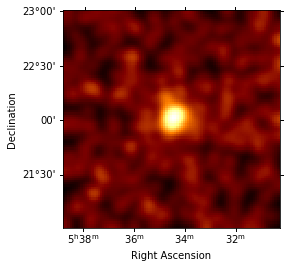

In [15]:
counts = analysis.datasets["stacked"].counts
counts.smooth("0.05 deg").plot_interactive()

## Save dataset to disk

It is common to run the preparation step independent of the likelihood fit, because often the preparation of maps, PSF and energy dispersion is slow if you have a lot of data. We first create a folder:

In [16]:
path = Path("analysis_1")
path.mkdir(exist_ok=True)

And then write the maps and IRFs to disk by calling the dedicated `write()` method:

In [17]:
filename = path / "crab-stacked-dataset.fits.gz"
analysis.datasets[0].write(filename, overwrite=True)

## Model fitting

Now we define a model to be fitted to the dataset. Here we use its YAML definition to load it:

In [18]:
model_config = """
components:
- name: crab
  type: SkyModel
  spatial:
    type: PointSpatialModel
    frame: icrs
    parameters:
    - name: lon_0
      value: 83.63
      unit: deg
    - name: lat_0 
      value: 22.14    
      unit: deg
  spectral:
    type: PowerLawSpectralModel
    parameters:
    - name: amplitude      
      value: 1.0e-12
      unit: cm-2 s-1 TeV-1
    - name: index
      value: 2.0
      unit: ''
    - name: reference
      value: 1.0
      unit: TeV
      frozen: true
"""

Now we set the model on the analysis object:

In [19]:
analysis.set_models(model_config)

Reading model.
Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.000              
    amplitude               :   1.00e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0                   :  83.630  deg         
    lat_0                   :  22.140  deg         

Component 1: FoVBackgroundModel

  Name                      : stacked-bkg
  Datasets names            : ['stacked']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




Finally we run the fit:

In [20]:
analysis.run_fit()

Fitting datasets.
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 274
	total stat : 20002.09



In [21]:
print(analysis.fit_result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 274
	total stat : 20002.09



This is how we can write the model back to file again:

In [22]:
filename = path / "model-best-fit.yaml"
analysis.models.write(filename, overwrite=True)

In [23]:
!cat analysis_1/model-best-fit.yaml

components:
-   name: crab
    type: SkyModel
    spectral:
        type: PowerLawSpectralModel
        parameters:
        -   name: index
            value: 2.557969980268659
            error: 0.10308963454666256
        -   name: amplitude
            value: 4.560060442821825e-11
            unit: cm-2 s-1 TeV-1
            error: 3.74932821333866e-12
        -   name: reference
            value: 1.0
            unit: TeV
            frozen: true
    spatial:
        type: PointSpatialModel
        frame: icrs
        parameters:
        -   name: lon_0
            value: 83.6197970324419
            unit: deg
            error: 0.003152541788027363
        -   name: lat_0
            value: 22.024555620265023
            unit: deg
            error: 0.0029673063916942715
-   type: FoVBackgroundModel
    datasets_names:
    - stacked
    spectral:
        type: PowerLawNormSpectralModel
        parameters:
        -   name: norm
            value: 0.7934178565433612
            er

### Flux points

In [24]:
analysis.config.flux_points.source = "crab"
analysis.get_flux_points()

Calculating flux points.

      e_ref               ref_flux        ...        dnde_err       is_ul
       TeV              1 / (cm2 s)       ...    1 / (cm2 s TeV)         
------------------ ---------------------- ... --------------------- -----
1.4125375446227544 1.9291772546702337e-11 ... 1.295998410538831e-12 False
3.1622776601683795  7.601548142361149e-12 ... 2.193938914815587e-13 False
  7.07945784384138 1.5660050084008048e-12 ... 5.874234520801372e-14 False


(array([0.41253754, 1.16701535, 2.06758551]), array([0.58272477, 1.84959468, 2.92054216]))


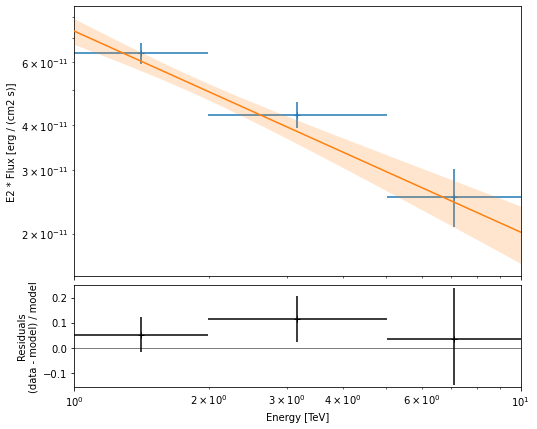

In [25]:
ax_sed, ax_residuals = analysis.flux_points.plot_fit()

The flux points can be exported to a fits table following the format defined [here](https://gamma-astro-data-formats.readthedocs.io/en/latest/spectra/flux_points/index.html) 

In [26]:
filename = path / "flux-points.fits"
analysis.flux_points.write(filename, overwrite=True)

## What's next

You can look at the same analysis without the high level interface in [analysis_2](analysis_2.ipynb)

You can see how to perform a 1D spectral analysis of the same data in [spectrum analysis](spectrum_analysis.ipynb)